In [1]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec

import numpy as np
import baltic as bt

typeface='Helvetica Neue'
mpl.rcParams['font.weight']=300
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.family']=typeface
mpl.rcParams['font.size']=22
mpl.rcParams['pdf.fonttype']=42

import re,glob,os,json

## cases with age group information available from:
# ftp://atviriduomenys.nvsc.lt/
data=json.load(open('/Users/evogytis/Downloads/COVID19.json','r'))


from itertools import islice
import numpy as np
def window(seq, n=2):
    "Returns a sliding window (of width n) over data from the iterable"
    "   s -> (s0,s1,...s[n-1]), (s1,s2,...,sn), ...                   "
    it = iter(seq)
    result = tuple(islice(it, n))
    if len(result) == n:
        yield result
    for elem in it:
        result = result[1:] + (elem,)
        yield result


In [2]:
# Iš viso	Amžius																																									
# 	0	1	2	3	4	5	6	7	8	9	10	11	12	13	14	15	16	17	18	19	20	21	22	23	24	25	26	27	28	29	30–34	35–39	40–44	45–49	50–54	55–59	60–64	65–69	70–74	75–79	80–84	≥85
# 2794090, 
demo={0: 27351, 1: 28300, 2: 28916, 3: 30365, 4: 30658, 5: 29404, 6: 28683, 7: 28989, 8: 28698, 9: 28738, 10: 29000, 11: 27350, 12: 25635, 13: 25367, 14: 25290, 15: 25288, 16: 25547, 17: 25242, 18: 26539, 19: 28310, 20: 30021, 21: 30161, 22: 30554, 23: 31342, 24: 32282, 25: 32620, 26: 35902, 27: 39017, 28: 39248, 29: 38589, (30,34): 187446, (35,39): 171793, (40,44): 174252, (45,49): 195470, (50,54): 201308, (55,59): 217731, (60,64): 196708, (65,69): 154540, (70,74): 126480, (75,79): 110410, (80,84): 90739, (85,np.inf): 73807}

demo={'0-9': 290102, 
      '10-19': 263568, 
      '20-29': 339736, 
      '30-39': 359239, 
      '40-49': 369722, 
      '50-59': 419039, 
      '60-69': 351248, 
      '70-79': 236890, 
      '80-': 164546} ## pop sizes for age groups


convert_age=lambda k: k if k not in ['','80-89','90-99','100-109','120-129','900-909'] else '80-'
# age_groups=set([p['Atvejo amžius'] for p in data if p['Atvejo amžius']!=''])
age_groups=set(demo.keys())
print('no age: %d'%(len([p for p in data if p['Atvejo amžius']==''])))


print(age_groups)

from datetime import datetime as dt
from datetime import timedelta

import time


start=dt.strptime('2020-03-01','%Y-%m-%d') ## begin timeline here
# start=dt.strptime('2020-03-04','%Y-%m-%d')
end=dt.today() ## end timeline on today
N_weeks=int(abs(end-start).days/7)+1 ## how many weeks fit inside between start date and today +1 week


timeline={(start+timedelta(days=i*7),start+timedelta(days=(i+1)*7-1)):{age: 0 for age in age_groups} for i in range(N_weeks)} ## prepare timeline

for patient in data: ## iterate over confirmed cases
    if patient['Atvejo amžius']!='': ## age available
        pdate=dt.strptime(patient['Atvejo patvirtinimo data'][:10],'%Y-%m-%d') ## get date of positive test
        
        for t in timeline:
#             print(t[0]<t[1],t[0]>t[1],pdate)
            if t[0]<=pdate<=t[1]: ## identify timeslice case belongs to
#                 time.sleep(10)
                timeline[t][convert_age(patient['Atvejo amžius'])]+=1 ## increment age group count for that week
print(sorted(timeline)[-1])

most_recent_case=dt.strftime(sorted([dt.strptime(patient['Atvejo patvirtinimo data'][:10],'%Y-%m-%d') for patient in data])[-1],'%Y-%m-%d') ## get most recent case available in data

most_recent_test='1900-01-01'

testing={} ## timeline of testing capacity
positives={} ## timeline of positives

## testing capacity and positivity information available from
# https://open-data-ls-osp-sdg.hub.arcgis.com/datasets/7c4b3397dc2c424aa400a5d1aed1fcc7_0
for line in open('/Users/evogytis/Downloads/COVID19_tyrimai_padieniui_pagal_laboratorijas.csv','r'): ## iterate over testing capacity
    l=line.strip('\n').split(',')
    if l[0]=='\ufefflab_name':
        print(l) ## header
    else:
        lab,date,test,pos,neg,ind,ob=l ## extract stats from line
        
        date=date[:10].replace('/','-') ## format date
        if bt.decimalDate(most_recent_test)<=bt.decimalDate(date): ## new more recent date available for testing
            most_recent_test=date
        
        if date not in testing: testing[date]=0
        if date not in positives: positives[date]=0
        
        pos,neg=int(pos),int(neg)
        
        testing[date]+=(pos+neg) ## add positives+negatives to total
        positives[date]+=pos ## add positives to positives
    
print(most_recent_test,most_recent_case)
# print(timeline)

no age: 195
{'10-19', '50-59', '60-69', '20-29', '30-39', '70-79', '0-9', '80-', '40-49'}
(datetime.datetime(2021, 2, 14, 0, 0), datetime.datetime(2021, 2, 20, 0, 0))
['\ufefflab_name', 'test_performed', 'test_type', 'tests_positive', 'tests_negative', 'gmp_indication', 'object_id']
2021-02-13 2021-02-13


0.0 4289.0


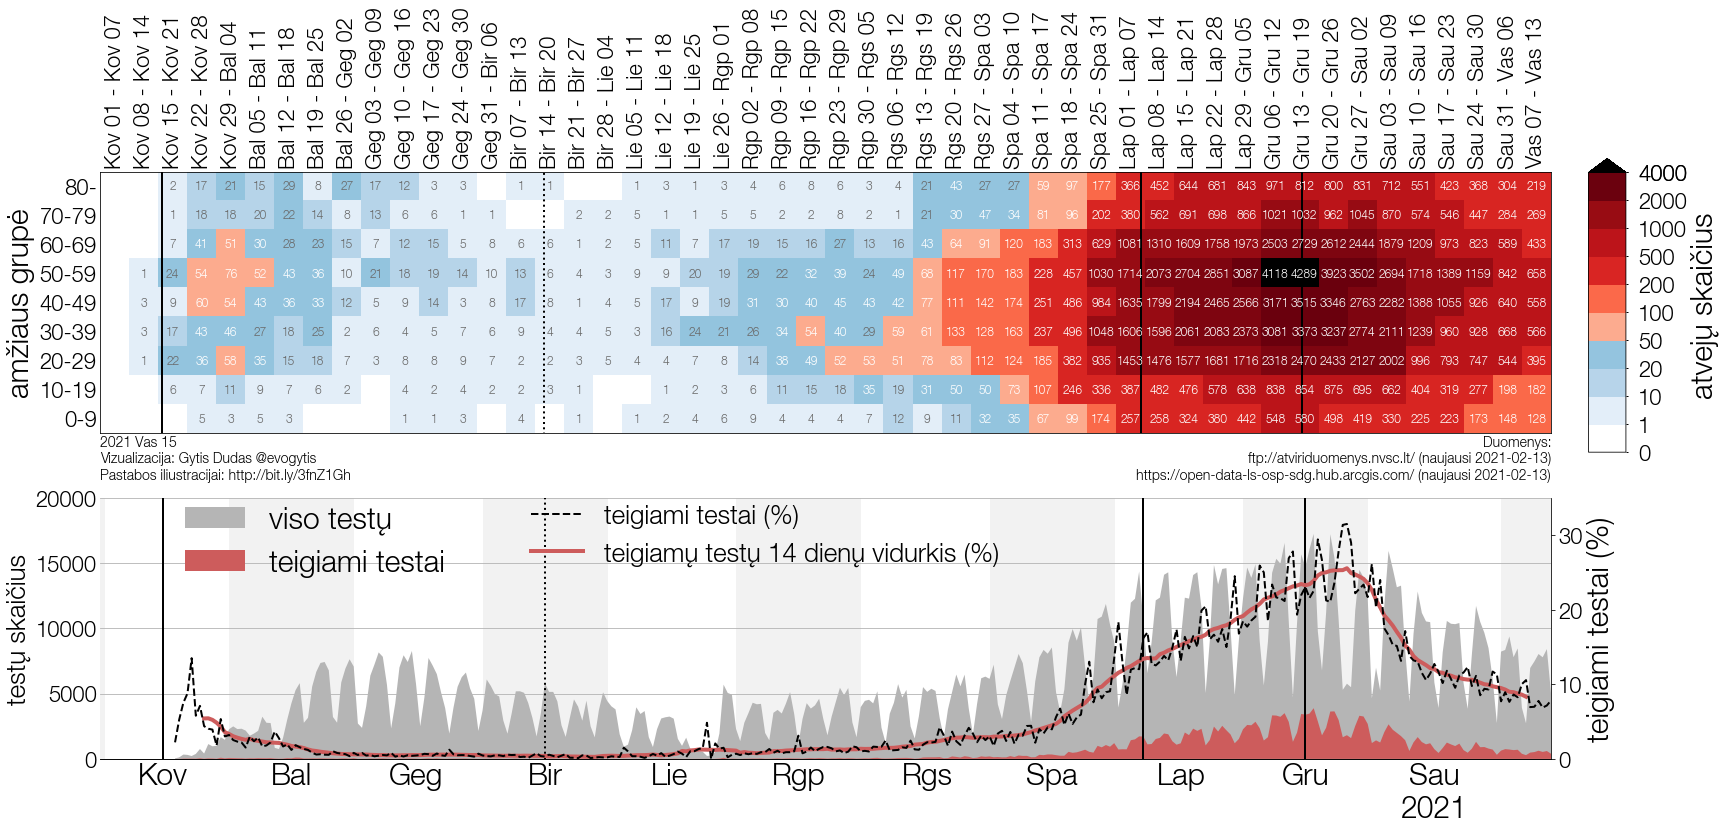

In [3]:
matrix=np.zeros((len(age_groups),len(timeline))) ## empty matrix

fig = plt.figure(figsize=(26,12),facecolor='w')

gs = GridSpec(2, 1,height_ratios=[1.5,1],hspace=0.0,wspace=0.0)
ax = plt.subplot(gs[0])


for t,T in enumerate(sorted(timeline.keys())): ## iterate over timeline
    for a,A in enumerate(sorted(age_groups)[::-1]): ## iterate over age groups
        matrix[a][t]=timeline[T][A] ## assign data to matrix
        
        c='w' ## white text by default
        if timeline[T][A]<30: ## if <30 cases - grey text
            c='dimgrey'
            if timeline[T][A]==0: ## if no cases - no text
                c='none'
        
        ax.text(t,a,timeline[T][A],size=12,va='center',ha='center',color=c,zorder=10000) ## add text


MAX=4000 ## peak of colour map

clist=[(0,'w'), ## 0 cases is white
       (1,mpl.cm.Blues(0.1)),
       (10,mpl.cm.Blues(0.3)),
       (20,mpl.cm.Blues(0.4)), ## <50 cases blue
       (50,mpl.cm.Reds(0.3)), ## >=50 cases red
       (100,mpl.cm.Reds(0.5)),
       (200,mpl.cm.Reds(0.7)),
       (500,mpl.cm.Reds(0.8)),
       (1000,mpl.cm.Reds(0.9)),
       (2000,mpl.cm.Reds(0.95)),
       (3000,mpl.cm.Reds(0.99)),
       (MAX,'k')] ## peak is black

boundaries,colours=zip(*clist)
cmap=mpl.colors.ListedColormap(colours) ## create colour map
norm = mpl.colors.BoundaryNorm(boundaries, cmap.N,extend='max') ## discrete colour map

quarantines=[[dt.strptime('2020-03-16','%Y-%m-%d'),dt.strptime('2020-06-16','%Y-%m-%d')],[dt.strptime('2020-11-07','%Y-%m-%d')],[dt.strptime('2020-12-16','%Y-%m-%d')]] ## add dates to mark

for q,Q in enumerate(quarantines): ## iterate over periods
    for t,T in enumerate(sorted(timeline)):
        for d,D in enumerate(Q): ## iterate over dates within periods
            if T[0]<=D<=T[1]: ## identify week in timeline
                ls='-'
                if d==1:
                    ls=':'
                frac=((D-T[0]).days)/7 ## identify fraction of week date belongs to
                
                ax.vlines(t-0.5+frac,-1,len(age_groups)+1,lw=2,ls=ls,color='k',zorder=100) ## add line
                

ax.imshow(matrix,norm=norm,cmap=cmap) ## plot cases matrix

print(matrix.min(),matrix.max())

months={'Jan': 'Sau', 'Feb': 'Vas', 'Mar': 'Kov', 
        'Apr': 'Bal', 'May': 'Geg', 'Jun': 'Bir', 
        'Jul': 'Lie', 'Aug': 'Rgp', 'Sep': 'Rgs', 
        'Oct': 'Spa', 'Nov': 'Lap', 'Dec': 'Gru'} ## translate months to Lithuanian

fmt_x=[] ## format x ticks
for t in sorted(timeline.keys()): ## iterate over weeks
    lt_mon=months[dt.strftime(t[0],'%b')] ## translate month to Lituanian
    s='%s %s'%(lt_mon,dt.strftime(t[0],'%d')) ## beginning of the week
    
    lt_mon=months[dt.strftime(t[1],'%b')]
    e='%s %s'%(lt_mon,dt.strftime(t[1],'%d')) ## end of the week
    fmt_x.append('%s - %s'%(s,e)) ## format week slice, add to x tick labels
    
ax.set_yticks(range(len(age_groups))) ## set age groups as y axis
ax.set_yticklabels(sorted(age_groups)[::-1])
    
ax.set_xticks(range(len(timeline))) ## set timeline as x axis
ax.set_xticklabels(fmt_x,rotation=90)
ax.tick_params(size=0)
ax.set_xlim(-0.5,len(timeline)-1.5)

ax.xaxis.tick_top()
ax.set_ylabel('amžiaus grupė',size=30)

axcb = fig.add_axes([0.92, 0.48, 0.02, 0.34], frame_on=False) ## colour bar subplot

Bs=[0,1,10,20,50,100,200,500,1000,2000,4000,MAX] ## boundaries to show
cb = mpl.colorbar.ColorbarBase(axcb,cmap=cmap,norm=norm,boundaries=Bs,ticks=Bs,extend='max',orientation='vertical',alpha=1.0,drawedges=False)

axcb.set_ylabel('atvejų skaičius',size=30)

axcb.xaxis.labelpad=10

axcb.tick_params(axis='y',which='both',direction='out',size=2,width=1,pad=10)

today='%s %s %s'%(dt.strftime(dt.now(),'%Y'),months[dt.strftime(dt.now(),'%b')],dt.strftime(dt.now(),'%d'))
ax.text(1.0,-0.01,'Duomenys:\n%s (naujausi %s)\n%s (naujausi %s)'%('ftp://atviriduomenys.nvsc.lt/',most_recent_case,'https://open-data-ls-osp-sdg.hub.arcgis.com/',most_recent_test),ha='right',va='top',transform=ax.transAxes,size=14) ## add information about data

discussion='http://bit.ly/3fnZ1Gh' ## Nov 23
ax.text(0.0,-0.01,'%s\nVizualizacija: Gytis Dudas @evogytis\nPastabos iliustracijai: %s'%(today,discussion),ha='left',va='top',transform=ax.transAxes,size=14) ## add information about author

######
ax = plt.subplot(gs[1]) ## secondary testing and positivity plot

xs=[bt.decimalDate(t) for t in sorted(testing)] ## get timeline
POS=[positives[t] for t in sorted(testing)]
TES=[testing[t] for t in sorted(testing)]

ax.fill_between(xs,TES,facecolor='#B5B5B5',label='viso testų',zorder=30) ## plot testing capacity in grey
ax.fill_between(xs,POS,facecolor='indianred',label='teigiami testai',zorder=100) ## plot positive tests in red


for q,Q in enumerate(quarantines): ## add quarantine lines
    for d,D in enumerate(Q):
        ls='-'
        if d==1:
            ls=':'
        ax.vlines(bt.decimalDate(dt.strftime(D,'%Y-%m-%d')),0,max(TES)*1.2,lw=2,ls=ls,color='k',zorder=100)
                

ax.set_ylabel('testų skaičius',size=26)

ax.legend(loc=(0.05,0.65),frameon=False,fontsize=30) ## add legend

xlo=bt.decimalDate(dt.strftime(sorted(timeline)[0][0],'%Y-%m-%d')) ## get extremes to limit x axis
xhi=bt.decimalDate(dt.strftime(sorted(timeline)[-2][-1],'%Y-%m-%d'))


ax2=ax.twinx() ## create a secondary plot for test positivity rate
ax2.set_ylabel('teigiami testai (%)',size=30)

positivity_percent=[p/t*100 if t>0 else np.nan for p,t in zip(POS,TES)] ## compute positivity
ax2.plot(xs,positivity_percent,ls='--',color='k',lw=2,label='teigiami testai (%)',zorder=2)


w_size=14 ## window size for sliding window
smoothed=list(map(np.mean,window(positivity_percent,w_size))) ## mean sliding window across raw data
smoothed_xs=[xs[i] for i in range(int(w_size/2),int(len(smoothed)+w_size/2))] ## positivity with 2 week smoothing

ax2.plot(smoothed_xs,smoothed,color='indianred',lw=4,zorder=1,label='teigiamų testų %d dienų vidurkis (%%)'%(w_size)) ## plot sliding window in black


ax2.legend(loc=(0.29,0.7),frameon=False,fontsize=26)

calendar_timeline=['2020-%02d-01'%(m) for m in range(1,13)]
calendar_timeline+=['2021-%02d-01'%(m) for m in range(1,4)]

ax.set_xticks([bt.decimalDate(t)+15/365 for t in calendar_timeline])
[ax.axvspan(bt.decimalDate(t),bt.decimalDate(t)+30/365,facecolor='k',edgecolor='none',alpha=0.05,zorder=0) for t in calendar_timeline if int(t.split('-')[1])%2==0] ## grey vertical blocks every other month
ax.set_xticklabels([months[bt.convertDate(t,'%Y-%m-%d','%b')] if t.split('-')[1]!='01' else '%s\n%s'%(months[bt.convertDate(t,'%Y-%m-%d','%b')],t.split('-')[0]) for t in calendar_timeline],size=30) ## format x tick labels with year if January, month otherwise

ax.set_xlim(xlo,xhi)

ax.grid(axis='y')

ax.tick_params(size=0)

ax.set_ylim(0,20000)
ax2.set_ylim(0,35)

[ax.spines[loc].set_visible(False) for loc in ax.spines if loc not in ['bottom']]
[ax2.spines[loc].set_visible(False) for loc in ax2.spines if loc not in ['bottom','right']]


plt.savefig('/Users/evogytis/Downloads/2020-Vas-14_atvejai.png',dpi=300,bbox_inches='tight')
plt.savefig('/Users/evogytis/Downloads/2020-Vas-14_atvejai.pdf',dpi=300,bbox_inches='tight')

plt.show()